In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import nltk 
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer


# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical




In [27]:
df = pd.read_csv('combined_dataset.csv', encoding='utf8')

In [28]:
df.shape

(21357, 3)

In [29]:
df.columns

Index(['id', 'comment', 'label'], dtype='object')

In [30]:
df.head(10)

,id,comment,label
0,1,The weather is nice today.,0
1,2,I need to buy some groceries.,0
2,3,What time does the store open?,0
3,4,She is reading a book.,0
4,5,The train arrives at 5 PM.,0
5,6,I have a meeting in the afternoon.,0
6,7,He enjoys playing football.,0
7,8,The cat is sleeping on the couch.,0
8,9,Water boils at 100 degrees Celsius.,0
9,10,I like to listen to music.,0


In [31]:
count = df.isna().sum()
precentange = df.isna().mean().round(4) * 100

dfMissing = pd.DataFrame({'count': count, 'precentange': precentange})
dfMissing.sort_values('count', ascending=False)

,count,precentange
id,0,0.0
comment,0,0.0
label,0,0.0


In [32]:
df.groupby(['label'])['label'].describe()[['count']]

,count
label,
0,6445.0
1,6445.0
2,8467.0


In [33]:
#calculate length of the comment
df['length'] = df['comment'].apply(len)
df.head()

,id,comment,label,length
0,1,The weather is nice today.,0,26
1,2,I need to buy some groceries.,0,29
2,3,What time does the store open?,0,30
3,4,She is reading a book.,0,22
4,5,The train arrives at 5 PM.,0,26


In [34]:
temp = df.groupby('label').count()['comment'].reset_index().sort_values(by='comment',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,comment
2,2,8467
0,0,6445
1,1,6445


In [36]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'  # or 'Noto Sans Devanagari' if installed


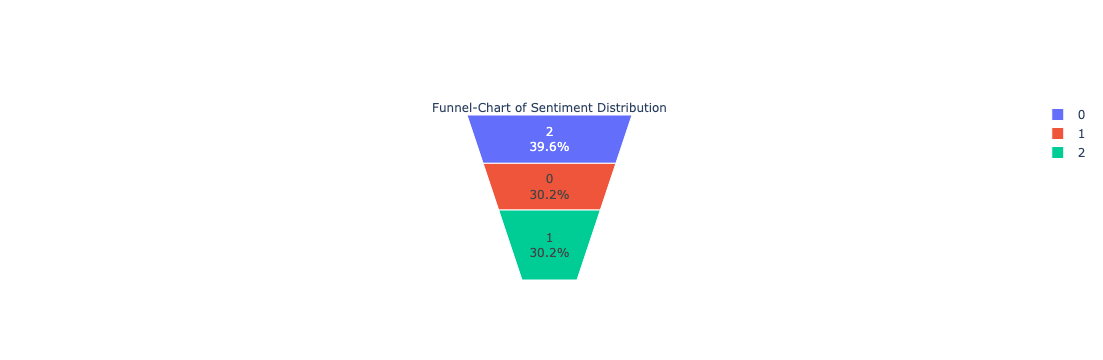

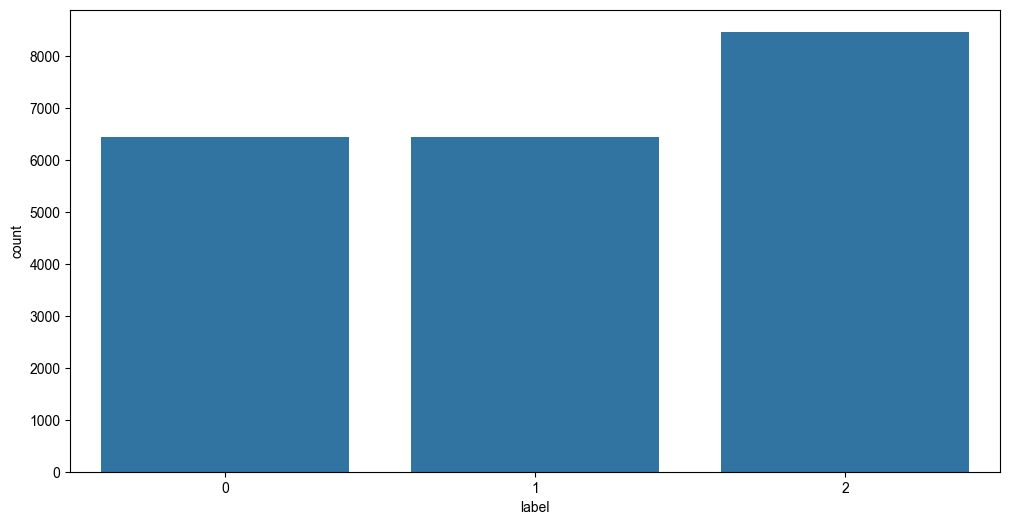

In [38]:
from plotly import graph_objs as go
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=df)
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.comment,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

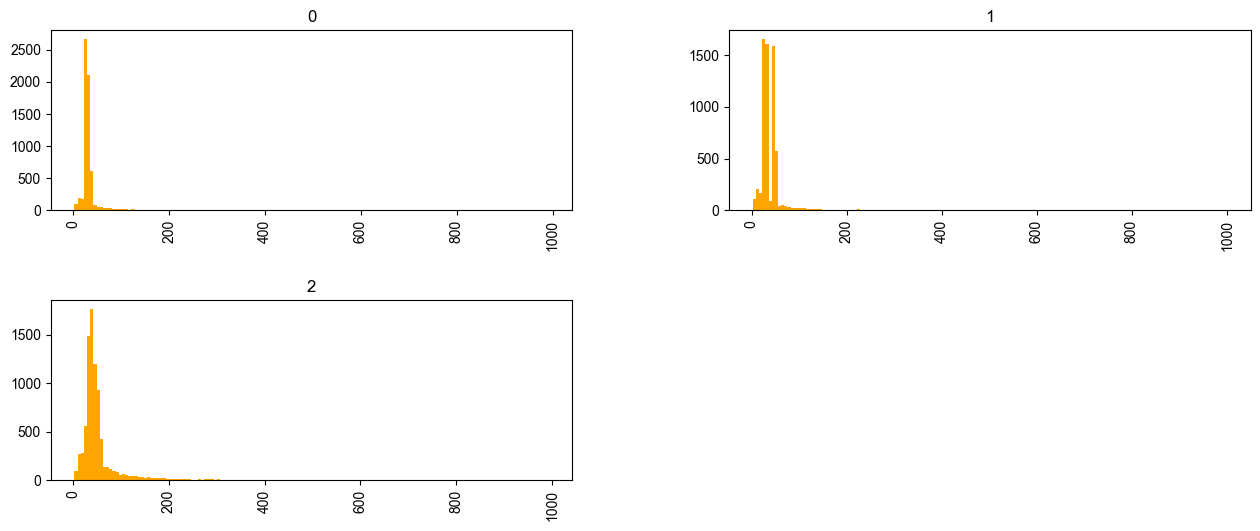

In [39]:
df.hist(column='length',by='label',figsize=(15,6), bins=150,color='orange')

In [40]:
df[df['label'] == 1]['length'].describe()

count    6445.000000
mean       42.319007
std        52.231698
min         2.000000
25%        27.000000
50%        33.000000
75%        45.000000
max      1000.000000
Name: length, dtype: float64

In [41]:
exclude = set(",.:;'\"-?!/´`%")
def removePunctuation(txt):
    return ''.join([(c if c not in exclude else " ") for c in txt])
    
def removeNumbers(txt):
    return ''.join(c for c in txt if not c.isnumeric())

In [42]:
df['cleaned'] = df['comment'].apply(lambda x: removePunctuation(x))
df.head()

,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at 5 PM


In [43]:
df['cleaned'] = df['cleaned'].apply(lambda x: removeNumbers(x))
df.head()

,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at PM


In [44]:
from collections import Counter

plt.rc('font', family='Lohit Devanagari')

results = Counter()
df.cleaned.str.split().apply(results.update)

most = results.most_common()
print(most[:10])

[('you', 4005), ('I', 3997), ('You', 3499), ('the', 3251), ('a', 3251), ('to', 2500), ('are', 2250), ('is', 2000), ('and', 1754), ('The', 1750)]


In [45]:
words = [word for i in df[df['label'] == 1]['cleaned'].str.split() for word in i]

counter = Counter(words)
most = counter.most_common(20)
    
most

[('You', 1500),
 ('Your', 1500),
 ('are', 1000),
 ('Keep', 1000),
 ('up', 1000),
 ('the', 1000),
 ('great', 1000),
 ('work', 1000),
 ('a', 1000),
 ('you', 1000),
 ('in', 501),
 ('an', 500),
 ('amazing', 500),
 ('person', 500),
 ('kindness', 500),
 ('makes', 500),
 ('world', 500),
 ('better', 500),
 ('place', 500),
 ('Believe', 500)]

In [46]:
words = [word for i in df[df['label'] == 0]['cleaned'].str.split() for word in i]

counter = Counter(words)
most = counter.most_common(20)
    
most

[('The', 1500),
 ('is', 1500),
 ('I', 1500),
 ('to', 1500),
 ('the', 1500),
 ('a', 1000),
 ('at', 1000),
 ('on', 501),
 ('weather', 500),
 ('nice', 500),
 ('today', 500),
 ('need', 500),
 ('buy', 500),
 ('some', 500),
 ('groceries', 500),
 ('What', 500),
 ('time', 500),
 ('does', 500),
 ('store', 500),
 ('open', 500)]

In [57]:
df.head()

,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at PM


In [48]:
import re,string,unicodedata
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from collections import Counter
import string

import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.pipeline import Pipeline

In [58]:
df

,id,comment,label,length,cleaned
0,1,The weather is nice today.,0,26,The weather is nice today
1,2,I need to buy some groceries.,0,29,I need to buy some groceries
2,3,What time does the store open?,0,30,What time does the store open
3,4,She is reading a book.,0,22,She is reading a book
4,5,The train arrives at 5 PM.,0,26,The train arrives at PM
...,...,...,...,...,...
21352,6341,ෆට්ට ඒත් ඉතින් ඔහේ ඔක්සිජන් ඔනී නැතී සෙට් එකක්...,0,57,ෆට්ට ඒත් ඉතින් ඔහේ ඔක්සිජන් ඔනී නැතී සෙට් එකක්...
21353,6342,ෆයිනලි,1,6,ෆයිනලි
21354,6343,ෆුකෙන් හිනා මේවට...,2,19,ෆුකෙන් හිනා මේවට
21355,6344,"ෆෝන් එක චාර්ජ් කරගනින්,29%. පට්ට.....",0,37,ෆෝන් එක චාර්ජ් කරගනින් පට්ට


In [50]:
df_la = pd.get_dummies(df, columns = ['label'])
df_la

,id,comment,length,cleaned,label_0,label_1,label_2
0,1,The weather is nice today.,26,The weather is nice today,True,False,False
1,2,I need to buy some groceries.,29,I need to buy some groceries,True,False,False
2,3,What time does the store open?,30,What time does the store open,True,False,False
3,4,She is reading a book.,22,She is reading a book,True,False,False
4,5,The train arrives at 5 PM.,26,The train arrives at PM,True,False,False
...,...,...,...,...,...,...,...
21352,6341,ෆට්ට ඒත් ඉතින් ඔහේ ඔක්සිජන් ඔනී නැතී සෙට් එකක්...,57,ෆට්ට ඒත් ඉතින් ඔහේ ඔක්සිජන් ඔනී නැතී සෙට් එකක්...,True,False,False
21353,6342,ෆයිනලි,6,ෆයිනලි,False,True,False
21354,6343,ෆුකෙන් හිනා මේවට...,19,ෆුකෙන් හිනා මේවට,False,False,True
21355,6344,"ෆෝන් එක චාර්ජ් කරගනින්,29%. පට්ට.....",37,ෆෝන් එක චාර්ජ් කරගනින් පට්ට,True,False,False


In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['label'],
                                                    test_size = 0.2, random_state = 42)
print(f'Data Split done.')

Data Split done.


In [56]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)


print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))


No. of feature_words:  29428


In [59]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Create a 3x3 confusion matrix assuming labels: 2=Negative, 0=Neutral, 1=Positive
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Reds)
    plt.xticks(range(3), ['Neutral', 'Positive', 'Negative'], fontsize=16, color='black')
    plt.yticks(range(3), ['Neutral', 'Positive', 'Negative'], fontsize=16)
    plt.show()


In [61]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'  # or any font you have installed


              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1287
           1       0.86      0.84      0.85      1308
           2       0.88      0.90      0.89      1677

    accuracy                           0.87      4272
   macro avg       0.87      0.86      0.87      4272
weighted avg       0.87      0.87      0.87      4272



<Figure size 640x480 with 0 Axes>

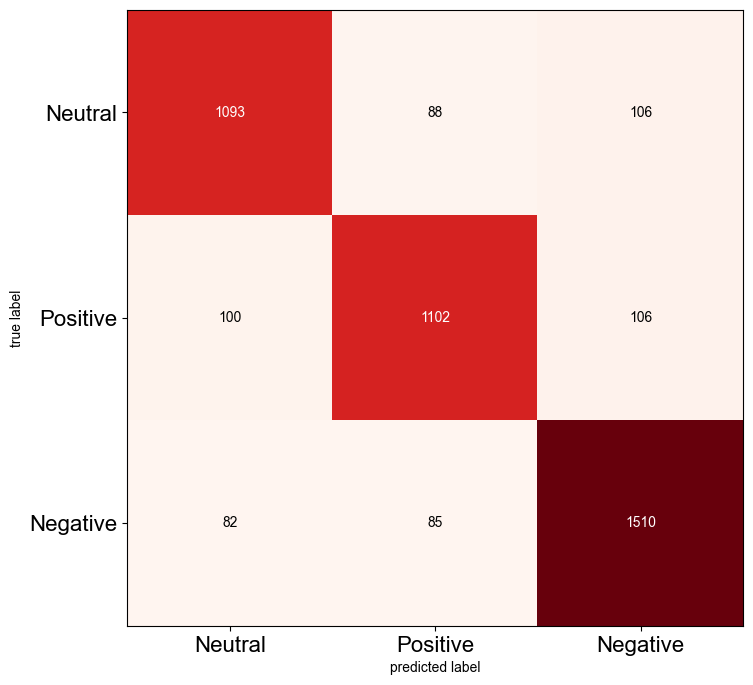

In [92]:
from sklearn.metrics import roc_curve, auc
dtc= DecisionTreeClassifier()
dtc.fit(X_train, y_train)
model_Evaluate(dtc)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>Logistic Regression</b></font><br>

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1287
           1       0.91      0.83      0.87      1308
           2       0.85      0.98      0.91      1677

    accuracy                           0.89      4272
   macro avg       0.89      0.88      0.88      4272
weighted avg       0.89      0.89      0.88      4272



<Figure size 640x480 with 0 Axes>

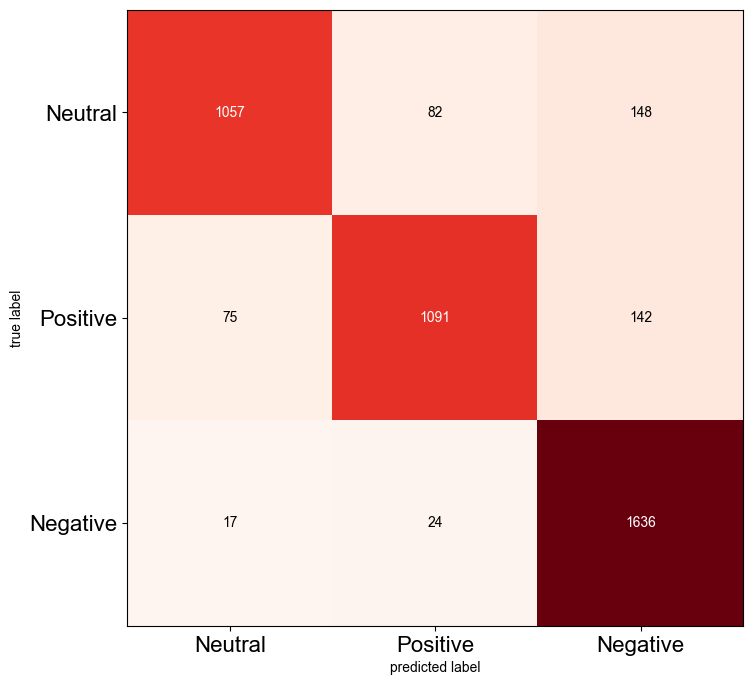

In [93]:
lr=LogisticRegression()
lr.fit(X_train, y_train)
model_Evaluate(lr)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>KNeighbors Clssifier</b></font><br>

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1287
           1       0.96      0.80      0.87      1308
           2       0.79      0.98      0.87      1677

    accuracy                           0.87      4272
   macro avg       0.90      0.86      0.87      4272
weighted avg       0.89      0.87      0.87      4272



<Figure size 640x480 with 0 Axes>

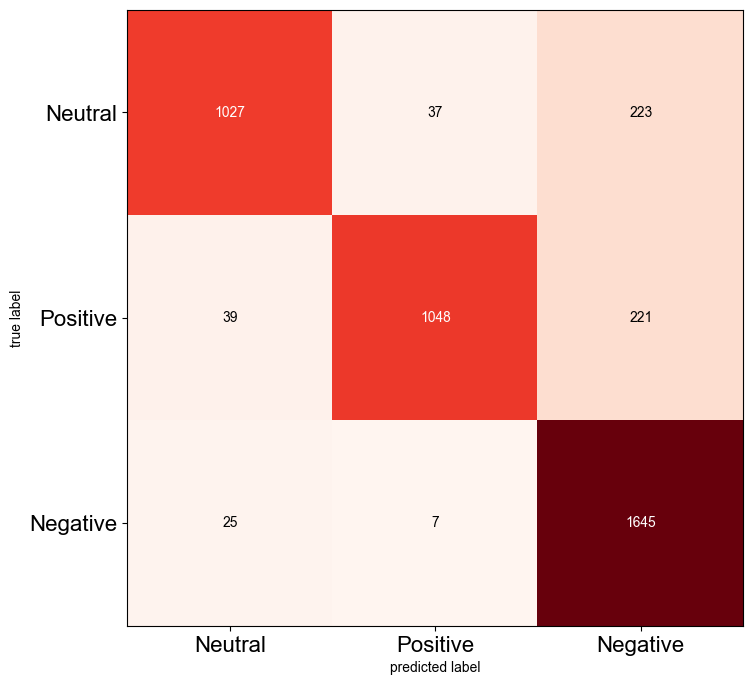

In [94]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

model_Evaluate(knn)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>AdaBoost Classifier</b></font><br>

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1287
           1       0.85      0.52      0.64      1308
           2       0.66      0.97      0.78      1677

    accuracy                           0.77      4272
   macro avg       0.83      0.75      0.76      4272
weighted avg       0.81      0.77      0.77      4272



<Figure size 640x480 with 0 Axes>

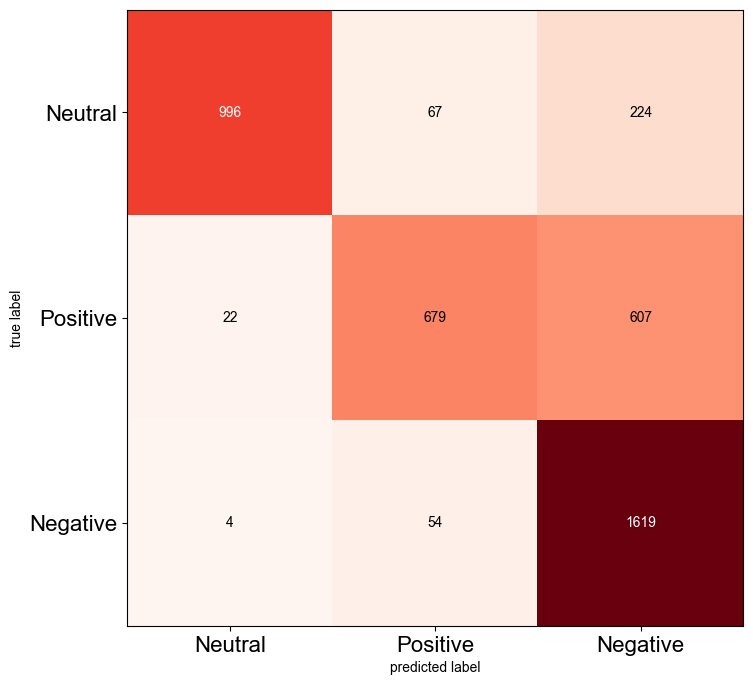

In [95]:
abc = AdaBoostClassifier()

abc.fit(X_train,y_train)

model_Evaluate(abc)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>MultiNomial NB</b></font><br>

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1287
           1       0.95      0.81      0.87      1308
           2       0.80      0.99      0.89      1677

    accuracy                           0.88      4272
   macro avg       0.90      0.87      0.88      4272
weighted avg       0.89      0.88      0.88      4272



<Figure size 640x480 with 0 Axes>

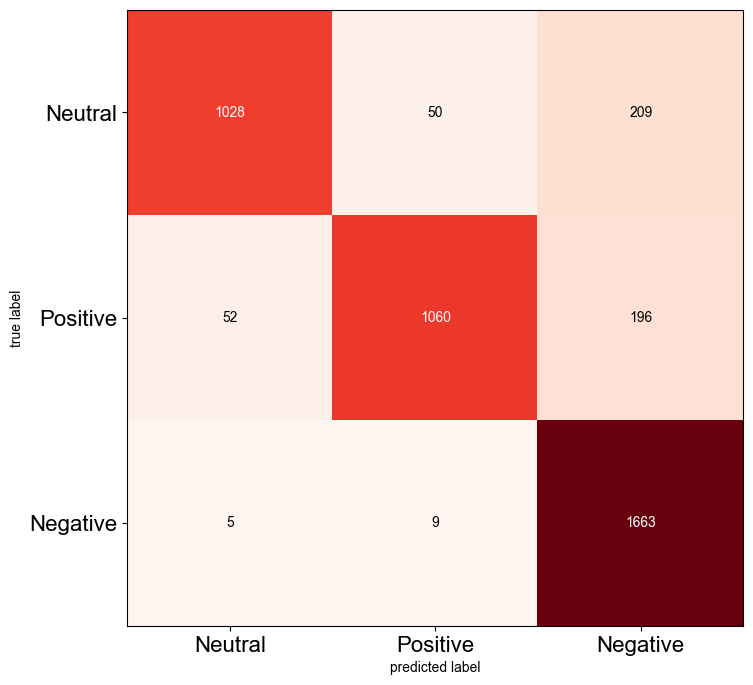

In [96]:
mnb = MultinomialNB()

mnb.fit(X_train,y_train)


model_Evaluate(mnb)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>Gradient Boosting Classifier</b></font><br>

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1287
           1       0.94      0.81      0.87      1308
           2       0.80      0.99      0.88      1677

    accuracy                           0.87      4272
   macro avg       0.90      0.86      0.87      4272
weighted avg       0.89      0.87      0.87      4272



<Figure size 640x480 with 0 Axes>

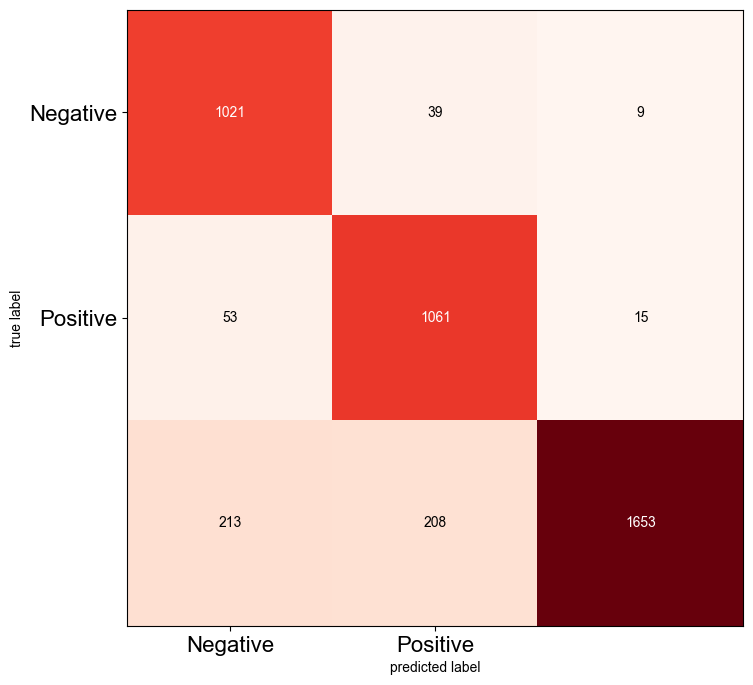

In [80]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train,y_train)

model_Evaluate(gbc)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>Random Forest Clssifier</b></font><br>

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1287
           1       0.91      0.83      0.87      1308
           2       0.84      0.97      0.90      1677

    accuracy                           0.88      4272
   macro avg       0.89      0.87      0.88      4272
weighted avg       0.89      0.88      0.88      4272



<Figure size 640x480 with 0 Axes>

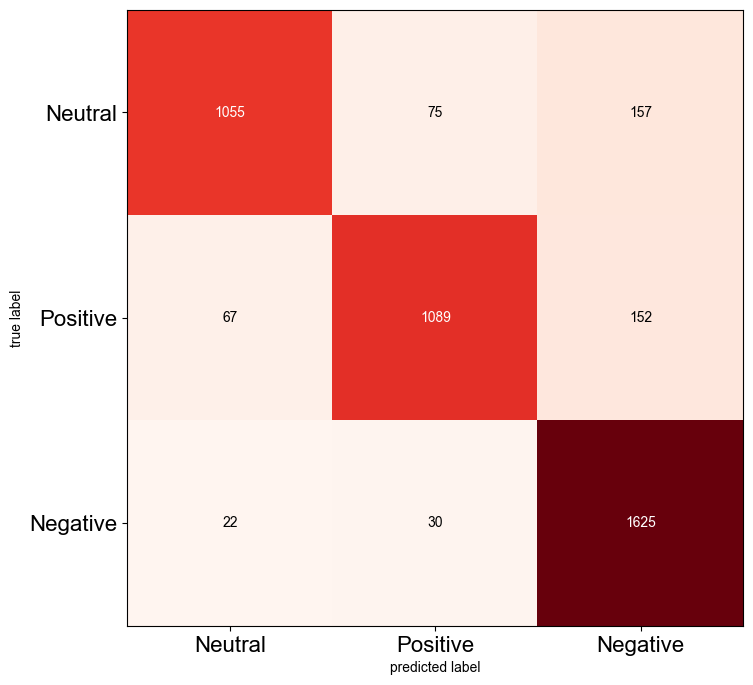

In [99]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC(random_state=42)

rfc.fit(X_train,y_train)

model_Evaluate(rfc)

<a id="#"></a>
    
<font size="+2" color="indigo"><b>SVC</b></font><br>

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1287
           1       0.91      0.83      0.87      1308
           2       0.84      0.98      0.90      1677

    accuracy                           0.88      4272
   macro avg       0.89      0.88      0.88      4272
weighted avg       0.89      0.88      0.88      4272



<Figure size 640x480 with 0 Axes>

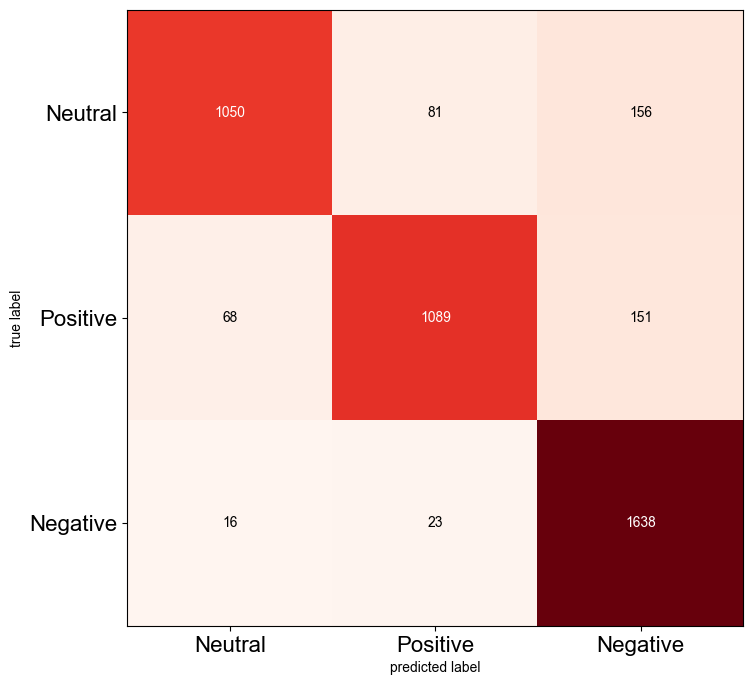

In [100]:
from sklearn.svm import SVC
svm=SVC()


svm.fit(X_train,y_train)

model_Evaluate(svm)

In [103]:
import joblib


# Define the SVC model
model = SVC(kernel='linear', random_state=42)  # You can change the kernel as needed

# Train the model
model.fit(X_train, y_train)  # X_train and y_train are your training features and labels



# Save vectorizer
joblib.dump(vectoriser, 'tfidf_vectorizer.pkl')

# Save trained model (e.g., DecisionTreeClassifier, or any other model)
joblib.dump(model, 'text_classification_model.pkl')


['text_classification_model.pkl']